In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.utils                          import R_lasso
from mrashpen.models                         import mixture_gaussian as mix_gauss
from mrashpen.inference                      import coordinate_descent_step as cd_step

from gradvi.priors import Ash
from gradvi.inference import  LinearRegression

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [2]:
def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def get_elbos(X, y, b, w, sk, s2):
    elbo1 = cd_step.elbo(X, y, sk, b, w, s2)

    dj     = np.sum(np.square(X), axis = 0)
    r      = y - np.mean(y) - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    elbo2  = elbo_py.scalemix(X, y, sk, b, w, s2,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    return elbo1, elbo2

In [3]:
n = 200
p = 500
p_causal = 10
pve = 0.7
rho = 0.5
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 100)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [4]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
winit  = mix_gauss.emfit(lasso_b, sk)
print ("Lasso initialization")

R[write to console]: Loading required package: Matrix



Lasso initialization


In [5]:
'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8, function_call = 'python', lbfgsb_call = 'python')
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 132.


In [27]:
prior = Ash(sk, wk = winit, scaled = True)
gvlin = LinearRegression(debug = False, display_progress = False, tol = 1e-8, get_elbo = True)
gvlin.fit(X, y, prior, b_init = lasso_b, s2_init = s2init)

2022-04-22 11:47:46,335 | gradvi.inference.linear_regression | INFO | Terminated at iteration 133.


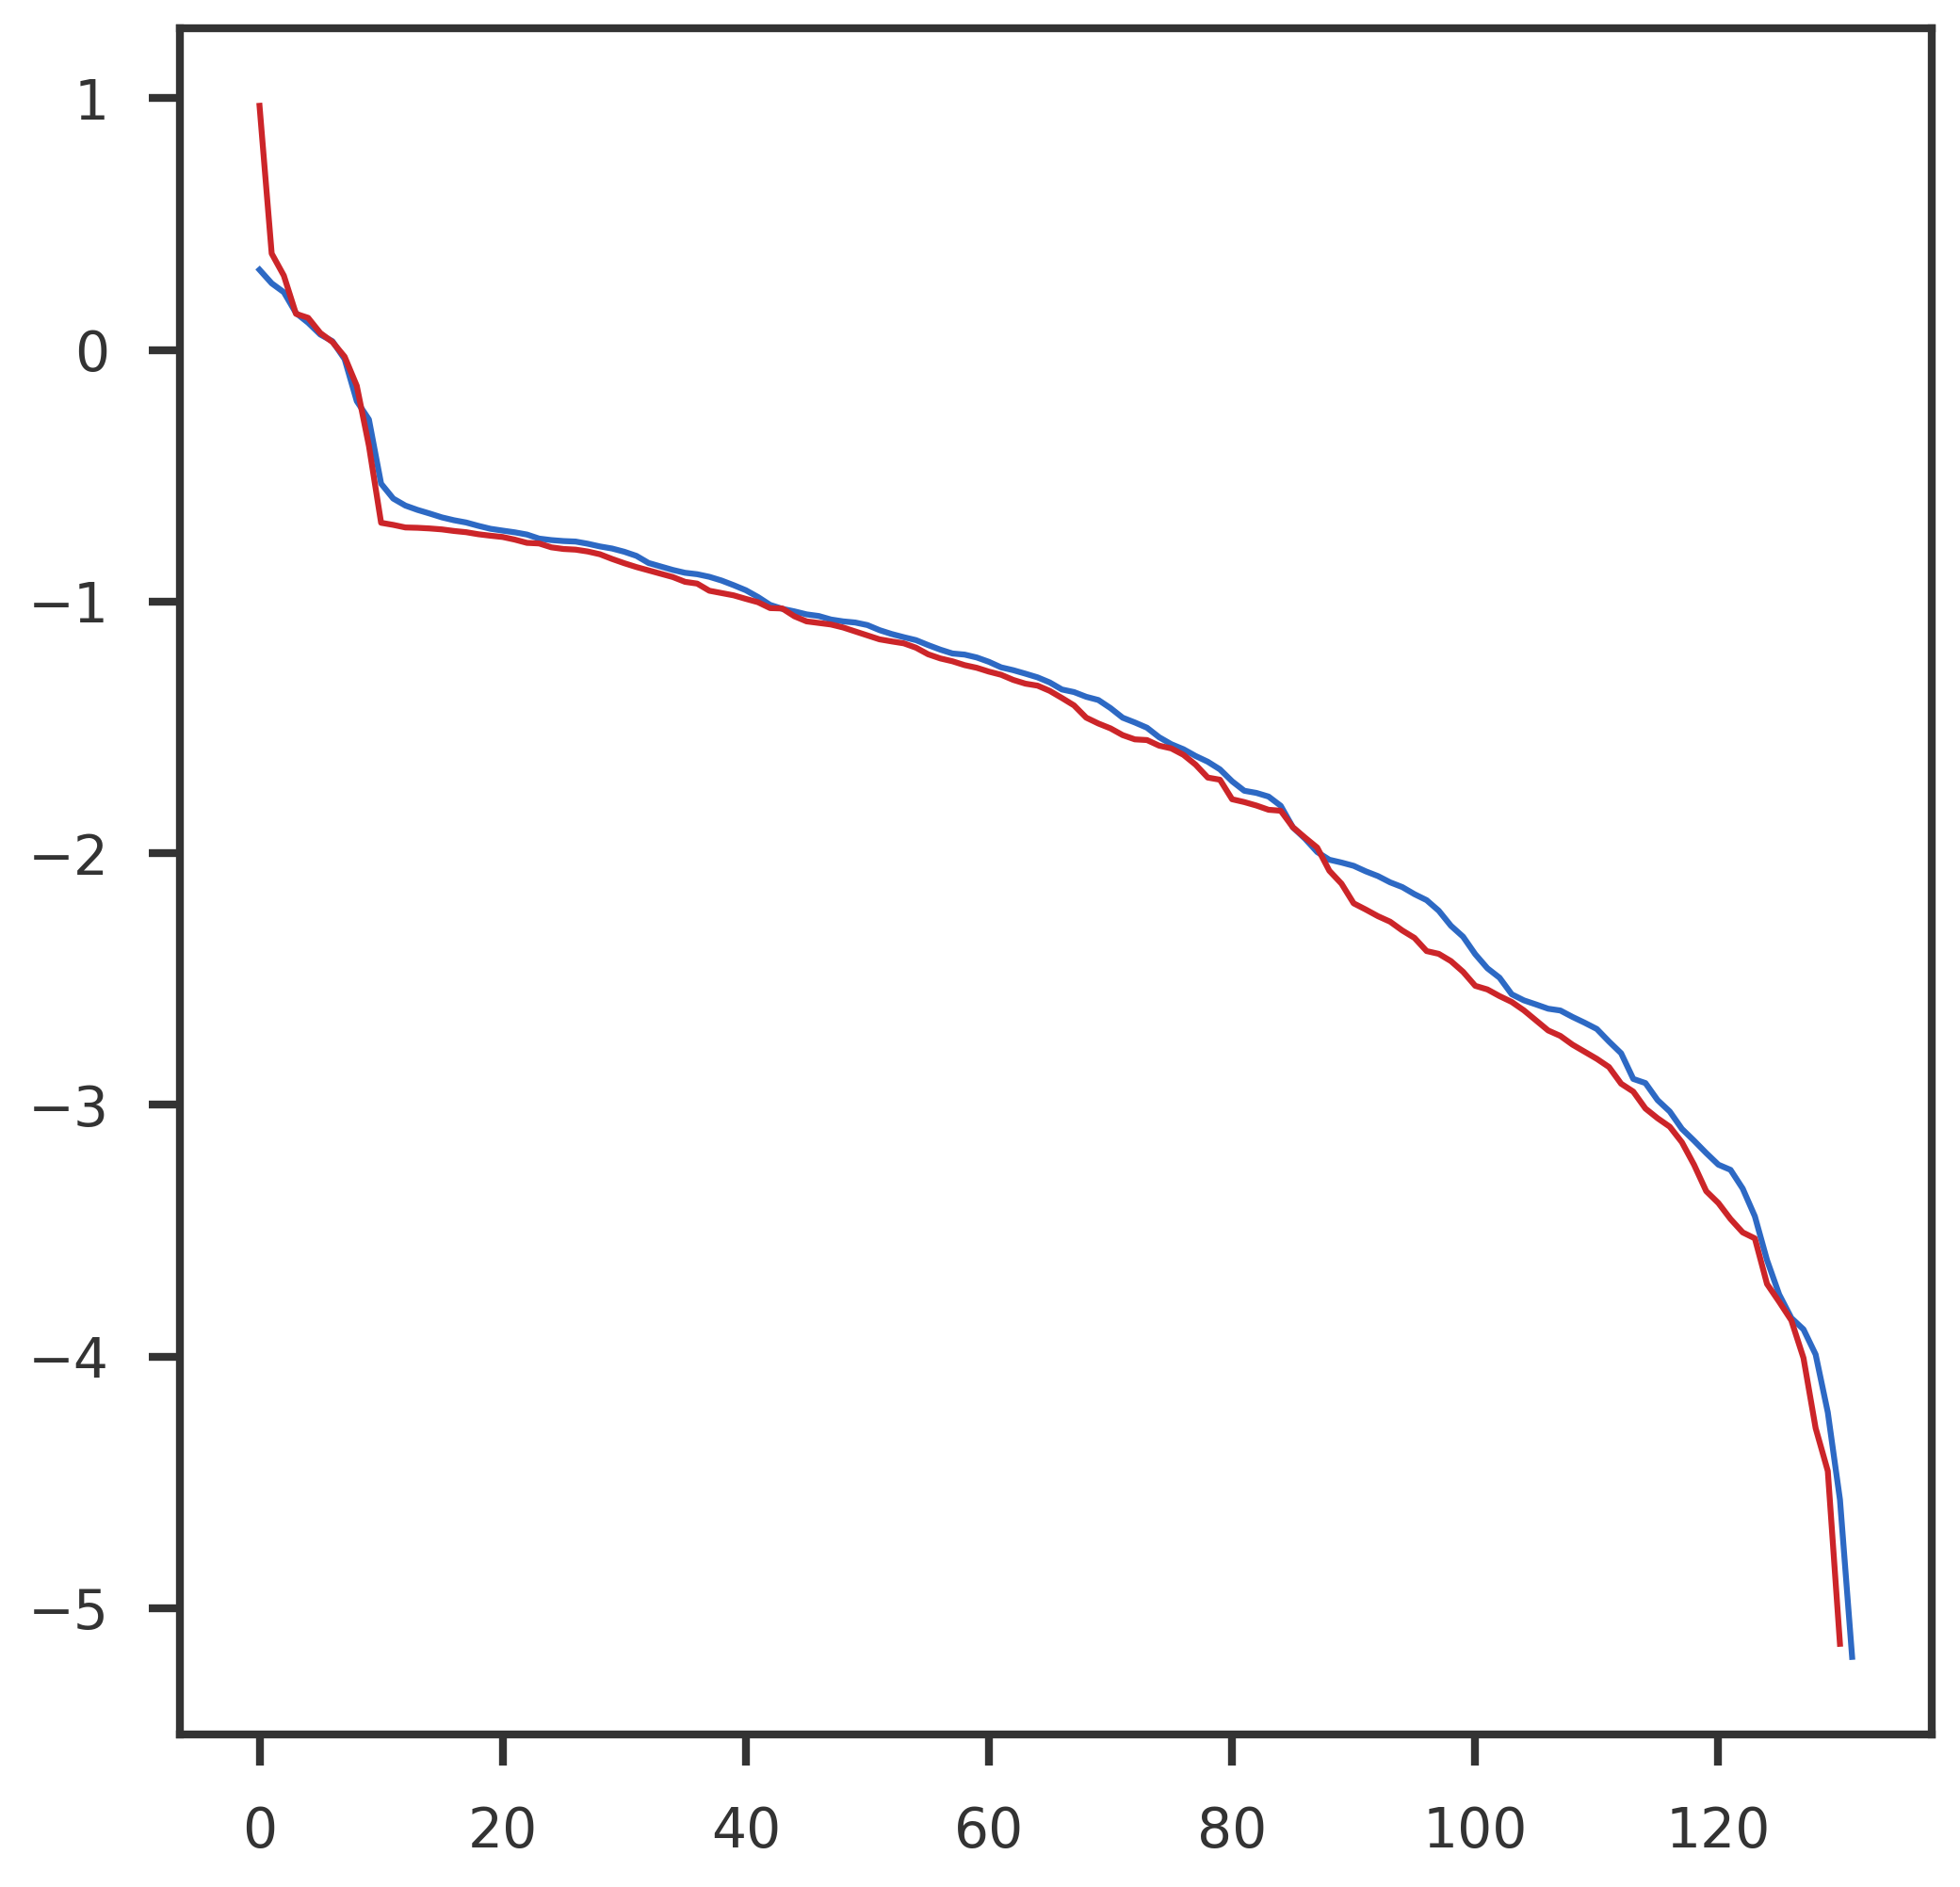

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(gvlin.niter - 1), np.log10(gvlin.obj_path[:-1] - gvlin.obj_path[-1]))
ax1.plot(np.arange(plr_lbfgs.niter - 1), np.log10(plr_lbfgs.obj_path[:-1] - plr_lbfgs.obj_path[-1]))
plt.show()

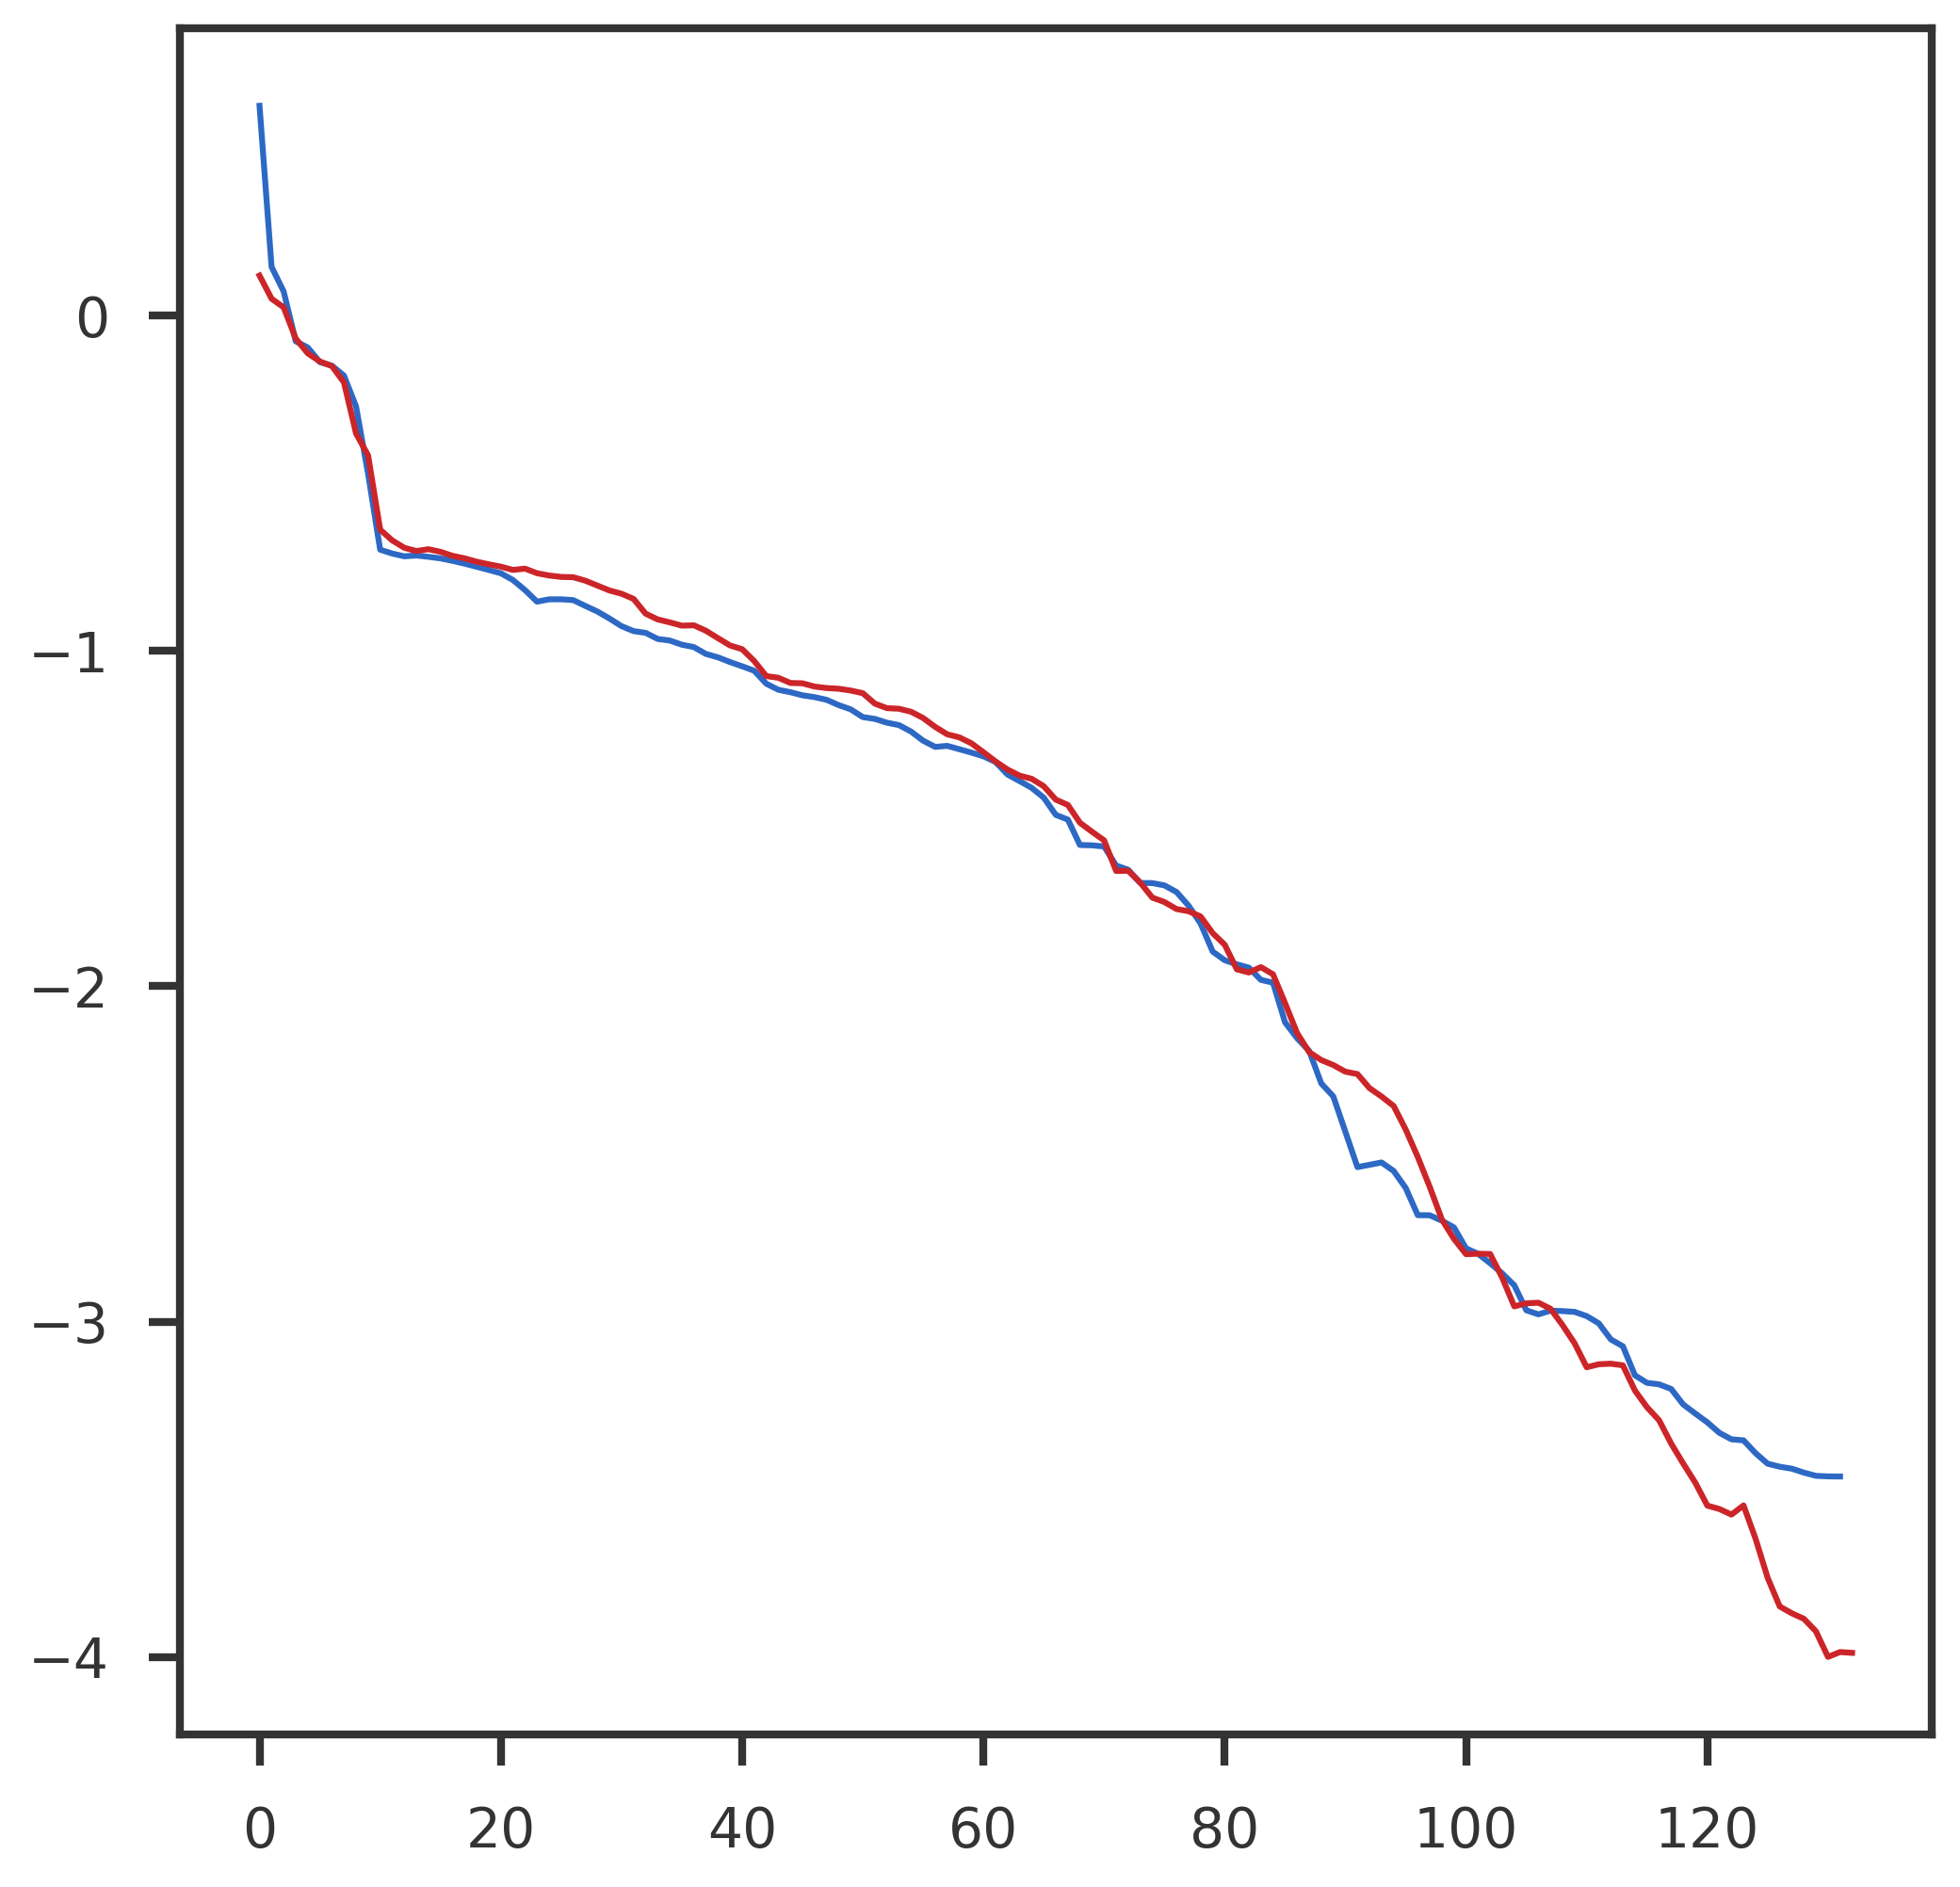

In [29]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
min_elbo = min(min(gvlin.elbo_path), min(plr_lbfgs.elbo_path))
ax1.plot(np.arange(plr_lbfgs.niter), np.log10(plr_lbfgs.elbo_path - min_elbo + 1e-4))
ax1.plot(np.arange(gvlin.niter), np.log10(gvlin.elbo_path - min_elbo + 1e-4))
plt.show()

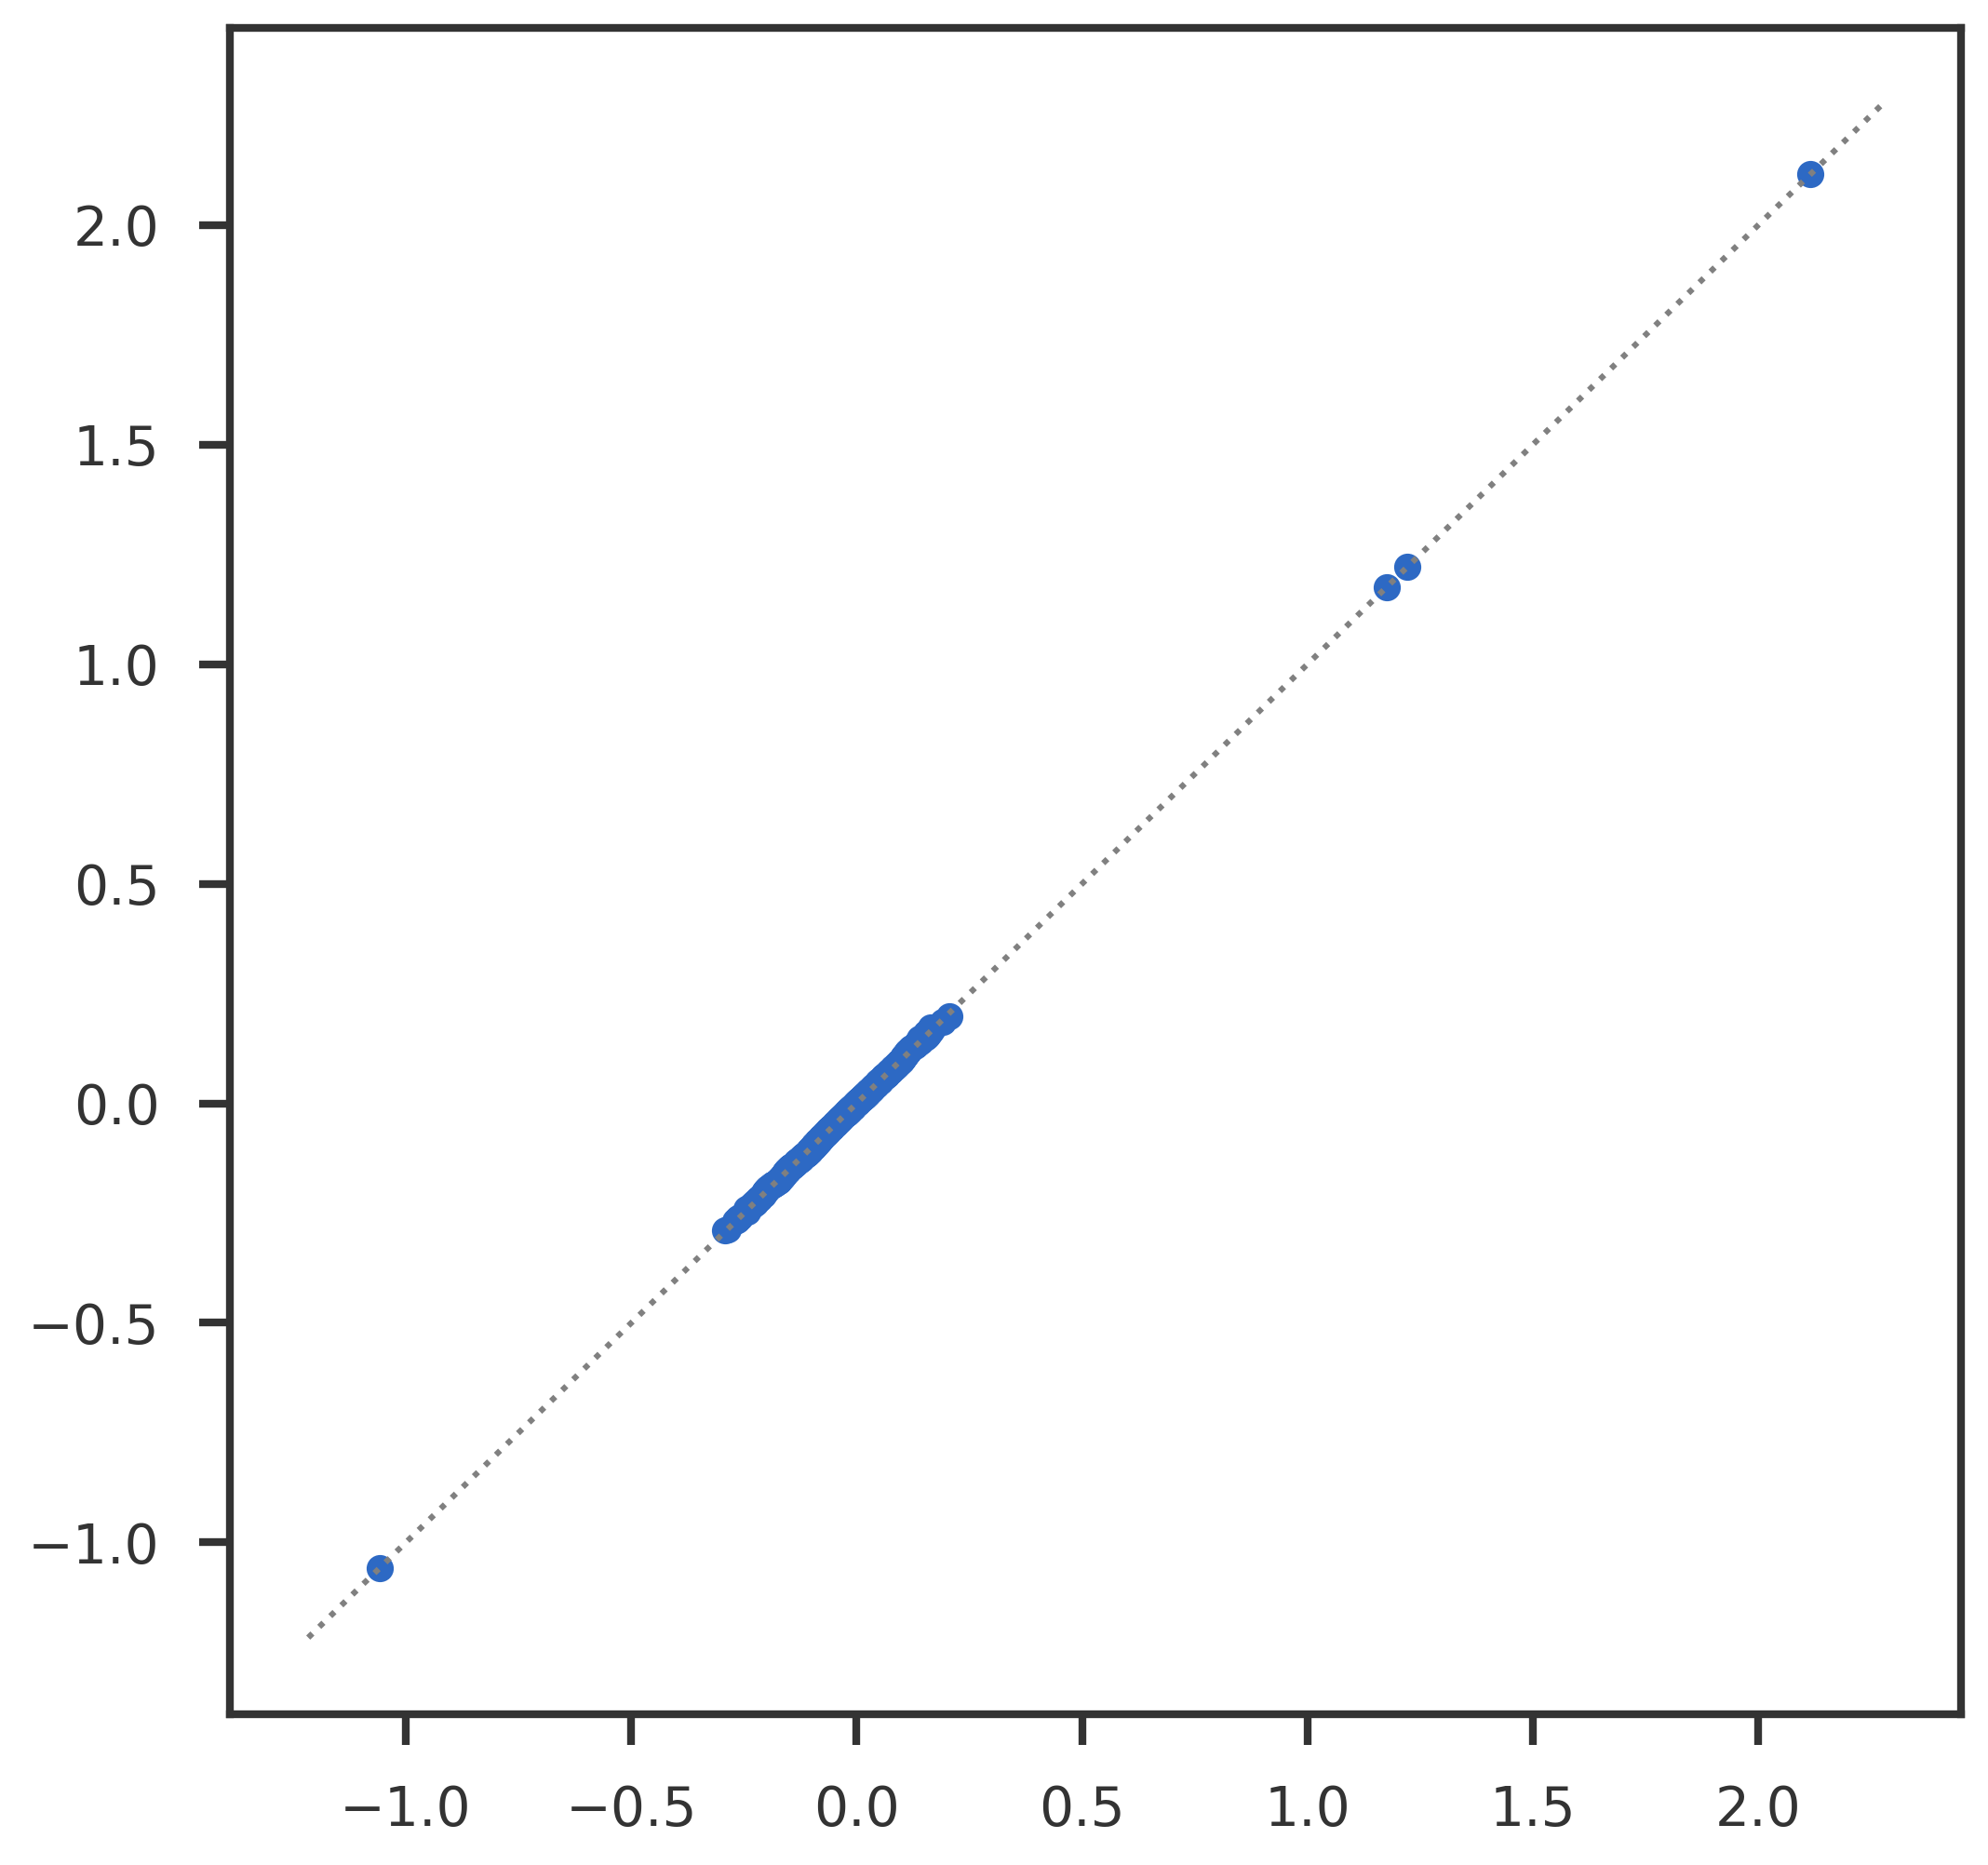

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(plr_lbfgs.theta, gvlin.theta)
mpl_utils.plot_diag(ax1)
plt.show()

In [31]:
np.allclose(plr_lbfgs.coef, gvlin.coef, atol = 1e-2, rtol = 1e-8)

True

### The results are slightly different because of numerical errors

In mr.ash.pen, I calculated d/ds2 directly from scaled Ash prior. In GradVI, I am calculating the d/dsj2 from the prior and converting it to d/ds2 in the model definition. This is because I want to define non-linear models.

In [32]:
from scipy import optimize as sp_optimize

bbounds = [(None, None) for x in plr_lbfgs._binit]
abounds = [(None, None) for x in plr_lbfgs._akinit]
s2bound = [(1e-8, None)]
# bounds can be used with L-BFGS-B.
bounds  = plr_lbfgs.combine_optparams(bbounds, abounds, s2bound)

params  = plr_lbfgs.combine_optparams(plr_lbfgs._binit, plr_lbfgs._akinit, plr_lbfgs._s2init)

p1 = sp_optimize.minimize(
        plr_lbfgs.objective,
        params,
        method = 'l-bfgs-b',
        jac = True,
        bounds = bounds,
        #callback = plr_lbfgs.callback,
        options = plr_lbfgs._opts
)
print(p1.nit, p1.fun)

132 -879.3704025737087


In [33]:
#from mrashpen.inference.penalized_regression import softmax
from mrashpen.models.plr_ash import PenalizedMrASH as PenMrASH
from gradvi.models.linear_model import LinearModel
from gradvi.inference import opt_utils

In [35]:
bbounds = [(None, None) for x in plr_lbfgs._binit]
abounds = [(None, None) for x in plr_lbfgs._akinit]
s2bound = [(1e-8, None)]

init_params = [plr_lbfgs._binit, plr_lbfgs._akinit, plr_lbfgs._s2init]

bounds = opt_utils.combine_optparams([bbounds, abounds, s2bound], gvlin._is_opt_list)
params = opt_utils.combine_optparams(init_params, gvlin._is_opt_list)

prior = Ash(sk, wk = winit, scaled = True)

def my_plr_model(X, y, b, s2, prior, dj):
    model = PenMrASH(X, y, b, np.sqrt(s2), prior.w, prior.sk,
                     dj = dj, debug = False, is_prior_scaled = True)
    obj = model.objective
    bgrad, wgrad, s2grad = model.gradients
    agrad = prior.wmod_grad(wgrad)
    return obj, bgrad, agrad, s2grad

def my_gvl_model(X, y, b, s2, prior, dj):
    model = LinearModel(X, y, b, s2, prior, dj = dj, debug = False)
    obj = model.objective
    bgrad = model.bgrad
    agrad = model.wmod_grad
    s2grad = model.s2grad
    return obj, bgrad, agrad, s2grad

def objective2(params):
    b, ak, s2 = opt_utils.split_optparams(params, init_params, gvlin._is_opt_list)
    prior.update_wmod(ak)
    
    """Get the objective function and gradients
    Switch between the two models to see how the two models 
    produce different restults.
    """
    #obj, bgrad, agrad, s2grad = my_plr_model(X, gvlin._y, b, s2, prior, gvlin._dj)
    obj, bgrad, agrad, s2grad = my_gvl_model(X, gvlin._y, b, s2, prior, gvlin._dj)
    
    # Combine gradients of all parameters for optimization
    grad = opt_utils.combine_optparams([bgrad, agrad, s2grad], gvlin._is_opt_list)
    return obj, grad

p2 = sp_optimize.minimize(
        objective2,
        params,
        method = 'l-bfgs-b',
        jac = True,
        bounds = bounds,
        #callback = plr_lbfgs.callback,
        options = plr_lbfgs._opts
)
print(p2.nit, p2.fun)

139 -879.3706437927106


In [36]:
gvlin.prior.w

array([9.90811644e-01, 1.90299955e-11, 4.50693326e-12, 2.31385856e-11,
       2.56175419e-10, 7.06997987e-10, 1.01440242e-09, 1.27219936e-09,
       1.65952428e-09, 2.43120913e-09, 4.04479805e-09, 7.66922172e-09,
       1.69548514e-08, 4.70200654e-08, 1.94667492e-07, 1.69779954e-06,
       6.26432441e-05, 9.03126017e-03, 9.24180404e-05, 5.93940487e-08])

In [38]:
prior.w_init

array([9.76000000e-01, 9.47545896e-03, 3.27026846e-03, 9.77404043e-04,
       2.43860307e-04, 9.85707339e-05, 6.02532995e-05, 4.85972481e-05,
       5.09707442e-05, 6.55846445e-05, 9.25624948e-05, 1.31656201e-04,
       1.84846449e-04, 2.61996729e-04, 3.85189939e-04, 5.91698717e-04,
       9.35373784e-04, 1.48091294e-03, 2.28427214e-03, 3.36052217e-03])

In [42]:
model = LinearModel(X, y, gvlin.theta, gvlin.residual_var, gvlin.prior, objtype = "reparametrize")
model.elbo(method = "mrash")

445.20852919810204

In [23]:
model.elbo(method = "nmeans")

447.85714715353845